In [1]:
%env CUDA_VISIBLE_DEVICES=""
import sys
import numpy as np
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_virtual_device_configuration(gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*7)])
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import lib

env: CUDA_VISIBLE_DEVICES=""


In [2]:
n_qubits = 3
dim = 2 ** n_qubits
rho = lib.randomPureState(dim)


measurements_cnt = 10_000

eps = 9.0/np.sqrt(measurements_cnt) # 9 sigma

sigma = tf.Variable(tf.eye(dim, dtype=tf.complex64) * (2 ** -n_qubits))

T = int(1e6)
L = 1
loss_object = tf.keras.losses.MeanAbsoluteError()

eta = np.sqrt(np.log(2) * n_qubits / (4*T))
# eta = eta*100

regret_bound = 2 * L * np.sqrt(np.log(2) * T * n_qubits)

print('eta:\t\t', eta)
print('regret_bound:\t', regret_bound)
print('eps:\t', eps)

eta:		 0.0007210134433004414
regret_bound:	 2884.053773201766
eps:	 0.09


In [3]:
loss_history = []
regret_history = []
metrics_history = []
fidelity_history = []
grad_history = []
cum_grad_history = []

cum_grad = tf.Variable(tf.zeros([dim, dim], dtype=tf.complex64))

t = -1
batch_size = 1000
epochs = T // batch_size
from tqdm import trange
for epoch in trange(epochs):
    train_X, train_y = lib.generate_dataset(rho, batch_size, measurements_cnt)
    train_y = train_y.astype('float64')
    x_var = tf.Variable(train_X, dtype=tf.complex64)
    y_var = tf.Variable(train_y, dtype=tf.complex64)
    
    for batch_i in range(batch_size):
        t += 1


        with tf.GradientTape() as tape:
            trace = tf.linalg.trace(tf.matmul(x_var[batch_i], sigma))
            loss = tf.abs(trace - y_var[batch_i])

        loss_history.append(loss)
        # loss for real state
        trace_true = tf.linalg.trace(tf.matmul(x_var[batch_i], rho.astype('complex64')))
        loss_true = tf.abs(trace_true - y_var[batch_i])
        
        regret_history.append(loss - loss_true)
        
#         if loss < 2.*eps/3: continue

        grad = tape.gradient(loss, sigma)
        grad_history.append(grad)
        
        cum_grad = cum_grad + grad
        cum_grad_history.append(cum_grad)

        sigma = tf.exp(-cum_grad * eta / L)
        sigma = tf.Variable(sigma / tf.linalg.trace(sigma))

100%|██████████| 1000/1000 [58:37<00:00,  3.52s/it]


/datadrive/aryzhikov/envs/tf/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


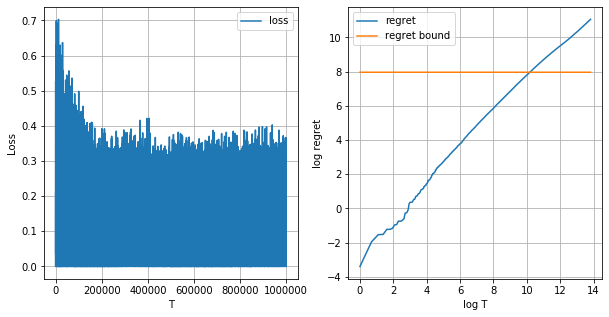

In [4]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='loss')
plt.xlabel('T')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
log_step = np.log(1+np.arange(len(regret_history)))
log_regret = np.log(np.cumsum(regret_history))
plt.plot(log_step, log_regret, label='regret')
plt.plot(log_step, [np.log(regret_bound)]*len(log_step), label='regret bound')
plt.ylabel('log regret')
plt.xlabel('log T')
plt.legend()
plt.grid()
plt.show()